In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve

In [2]:
clients = pd.read_csv('data/initial/CLIENTS.csv')
features = pd.read_csv('data/features/features_2.csv')

dataset = pd.merge(clients, features, left_on='CLIENT_ID', right_on='client_id').drop(columns=['client_id', 'CLIENT_ID'])
train_dataset = dataset[dataset['IS_TRAIN'] == True].drop(columns=['IS_TRAIN'])
test_dataset = dataset[dataset['IS_TRAIN'] == False].drop(columns=['IS_TRAIN'])

X = train_dataset.drop(columns=['TARGET'])
X_test = test_dataset.drop(columns=['TARGET'])
y = train_dataset['TARGET']
y_test = test_dataset['TARGET']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Logistic regression

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# noinspection PyTypeChecker
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        solver='lbfgs',
        max_iter=1000,
        class_weight='balanced',
        n_jobs=8,
        random_state=42,
    )
)
model.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [4]:
y_pred = model.predict(X_valid)
y_pred_proba = model.predict_proba(X_valid)[:, 1]

Gini Coefficient:  0.5446571330686465


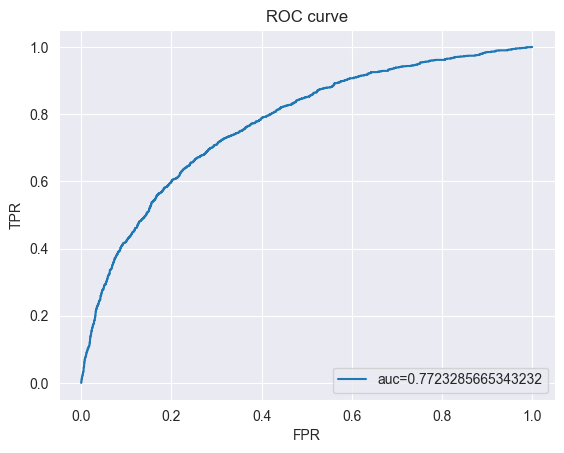

In [5]:
roc_auc = roc_auc_score(y_valid, y_pred_proba)
gini_coef = 2 * roc_auc - 1
print('Gini Coefficient: ', gini_coef)

# Roc curve
fpr, tpr, _ = roc_curve(y_valid,  y_pred_proba)
plt.plot(fpr, tpr, label='auc=' + str(roc_auc))
plt.legend(loc='lower right')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [6]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

       False       0.88      0.72      0.79      4185
        True       0.45      0.69      0.54      1374

    accuracy                           0.71      5559
   macro avg       0.66      0.71      0.67      5559
weighted avg       0.77      0.71      0.73      5559



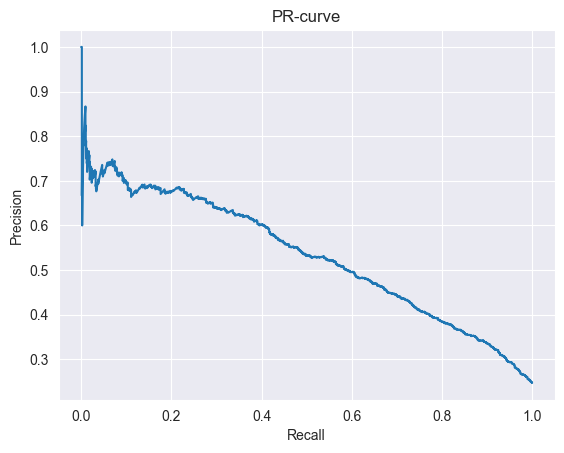

In [7]:
# PR-curve
precision, recall, _ = precision_recall_curve(y_valid,  y_pred_proba)
plt.plot(recall, precision)
plt.title('PR-curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

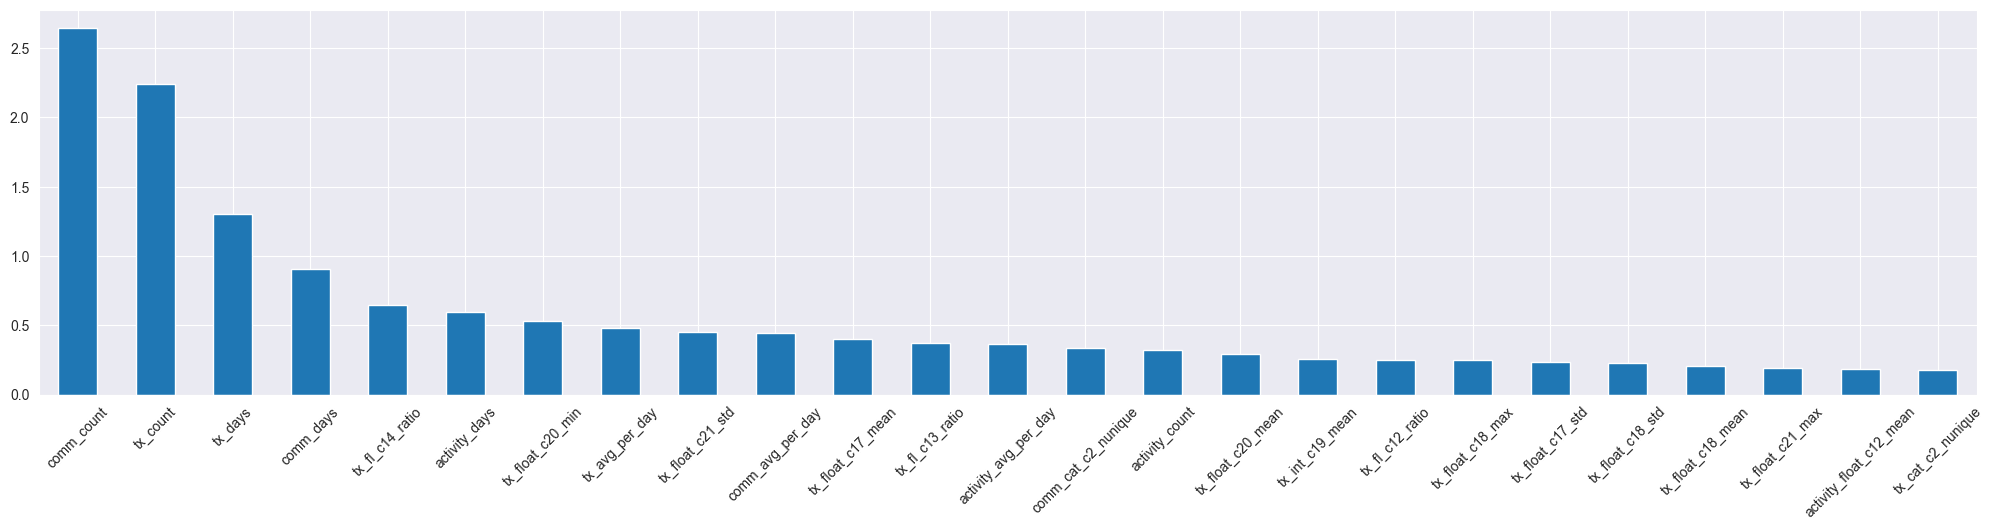

In [17]:
# Feature importance

coefs = model.named_steps['logisticregression'].coef_[0]
features_importance = pd.Series(coefs, index=X.columns).map(abs).sort_values(ascending=False)
features_importance.head(25).plot(kind='bar', figsize=(25, 5))
plt.xticks(rotation=45)
plt.show()